This notebook is for generating trajectory data to feed into the interpolation

Glider track: "survey" is a function of lat, lon, time, depth

Here let's make our survey in the Southern Ocean so we can sample the "ACC_SMST" data acquired using the Pre-SWOT_Numerical_Sumulation_Demo notebook. Lon is from 150 to 154, lat is from -57 to -53

In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from math import radians, degrees, sin, cos, asin, acos, sqrt

# great circle distance (from Jake Steinberg)
def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2)))


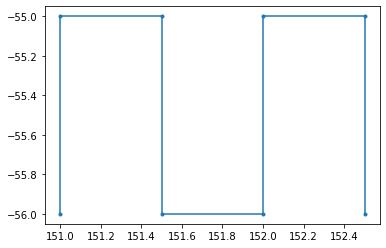

In [2]:
# --------- define sampling: change the values in this section -------
REGION = 'ACC_SMST'  # Pre-SWOT llc4320 dataset name
SAMPLING_TYPE = 'glider' # uctd or glider ... could add others
PATTERN = 'lawnmower' # back-forth or lawnmower ... could add others
survey_time_total = 30 * 86400 # if non-zero, limits the survey to a total time (NOTE: could make this optional)
    
    
# typical speeds and depth ranges based on platform 
if SAMPLING_TYPE == 'uctd':
    # typical values for uctd sampling:
    zrange = [-5, -500] # depth range of profiles (down is negative)
    hspeed = 5 # platform horizontal speed in m/s
    vspeed = 1 # platform vertical (profile) speed in m/s (NOTE: may want different up/down speeds)

elif SAMPLING_TYPE == 'glider':
    # typical values for glider sampling:
    zrange = [-1, -1000] # depth range of profiles (down is negative)
    hspeed = 0.25 # platform horizontal speed in m/s
    vspeed = 0.25 # platform vertical (profile) speed in m/s  (NOTE: is this typical?)
    
# define x & y waypoints and z range
# xwaypoints & ywaypoints must have the same size
if PATTERN == 'lawnmower':
    # "mow the lawn" pattern - define all waypoints
    xwaypoints = [151, 151, 151.5, 151.5, 152, 152, 152.5, 152.5]
    ywaypoints = [-56, -55,   -55,   -56, -56, -55, -55, -56] 
elif PATTERN == 'back-forth':
    # repeated back & forth transects - define the end-points
    xwaypoints = [151, 152]
    ywaypoints = [-56, -55]
    # repeat waypoints based on # of transects: 
    dkm_per_transect = great_circle(xwaypoints[0], ywaypoints[0], xwaypoints[1], ywaypoints[1]) # distance of one transect in km
    t_per_transect = dkm_per_transect * 1000 / hspeed # time per transect, seconds
    num_transects = np.round(sample_time_total / t_per_transect)
    for n in np.arange(num_transects):
        xwaypoints = np.append(xwaypoints, xwaypoints[-2])
        ywaypoints = np.append(ywaypoints, ywaypoints[-2])

plt.plot(xwaypoints, ywaypoints,'.-')


In [3]:
# time resolution of sampling (dt):
# use the time between vertical measurements
# for now, use a constant  vertical resolution (can change this later)
zresolution = 10 # meters
zprofile = np.arange(zrange[0],zrange[1],-zresolution) # depths for one profile
ztwoway = np.append(zprofile,zprofile[-1:0:-1])

dt = zresolution / vspeed # sampling resolution in seconds
# for each timestep dt 
deltah = hspeed*dt # horizontal distance traveled per sample
deltav = vspeed*dt # vertical distance traveled per sample


# determine the sampling locations in 2-d space
# - initialize sample locations xs, ys, zs, ts
xs = []
ys = []
zs = []
ts = []
dkm_total = 0 
for w in np.arange(len(xwaypoints)-1):
    # interpolate between this and the following waypoint:
    dkm = great_circle(xwaypoints[w], ywaypoints[w], xwaypoints[w+1], ywaypoints[w+1])
    # number of time steps (vertical measurements) between this and the next waypoint
    nstep = int(dkm*1000 / deltah) 
    yi = np.linspace(ywaypoints[w], ywaypoints[w+1], nstep)
    xi = np.linspace(xwaypoints[w], xwaypoints[w+1], nstep)
    xi = xi[0:-1] # remove last point, which is the next waypoint
    xs = np.append(xs, xi) # append
    yi = yi[0:-1] # remove last point, which is the next waypoint
    ys = np.append(ys, yi) # append
    dkm_total = dkm_total + dkm
    t_total = dkm_total * 1000 / hspeed
    # cut off the survey after survey_time_total, if specified
    if survey_time_total > 0 and t_total > survey_time_total:
        break

# depths: repeat (tile) the two-way sampling depths (NOTE: for UCTD sampling, often only use down-cast data)
# how many profiles do we make during the survey?
n_profiles = np.ceil(xs.size / ztwoway.size)
zs = np.tile(ztwoway, int(n_profiles))
zs = zs[0:xs.size]
# sample times: (units are in seconds since zero)
ts = dt * np.arange(xs.size) # time of each sample

In [10]:
# put into the survey dataset:
survey = xr.Dataset(
    dict(
        lon = xr.DataArray(xs,dims='points'),
        lat = xr.DataArray(ys,dims='points'),
        time = xr.DataArray(ts,dims='points'),
        dep = xr.DataArray(zs,dims='points')
    )
)

# save the track so we can load it with something else (can change this later)
dv_encoding = {'netcdf4'}
survey.to_netcdf('survey_trajectory_' + REGION + '_' + SAMPLING_TYPE + '_' + PATTERN + '.nc')

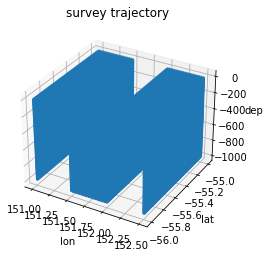

In [5]:
# plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xs, ys, zs, marker='.')

ax.set_xlabel('lon')
ax.set_ylabel('lat')
ax.set_zlabel('dep')
ax.set_title('survey trajectory')
plt.show()